# Predict survival on the Titanic
In this Lab, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy

### Dataset
The dataset contains 891 observations of 12 variables:
* **PassengerId**: Unique ID for each passenger
* **Survived**: Survival (0 = No; 1 = Yes)
* **Pclass**: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* **Name**: Name
* **Sex**: Sex
* **Age**: Age
* **Sibsp**: Number of Siblings/Spouses Aboard
* **Parch**: Number of Parents/Children Aboard
* **Ticket**: Ticket Number
* **Fare**: Passenger Fare
* **Cabin**: Cabin
* **Embarked** Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
titanic = pd.read_csv("titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# print some info about the dataframe
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Looks like there are some Nan values, let's see how many for each column

In [4]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Cabin** contains a lot of Nan values, we'll drop this column <br>
We'll replace the Nan values in **Age** with the age's median, and the ones in **Embarked** with **'S'**, which is the most frequent one in this column

In [5]:
# your code here to drop Cabin
titanic.drop('Cabin', axis=1, inplace=True)
# check the fillna documentation: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
titanic["Embarked"].fillna(titanic["Embarked"].mode()[0], inplace = True)
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Visualization

survival rate = 0.3838383838383838


<AxesSubplot:title={'center':"Label's Balance"}, xlabel='Survived'>

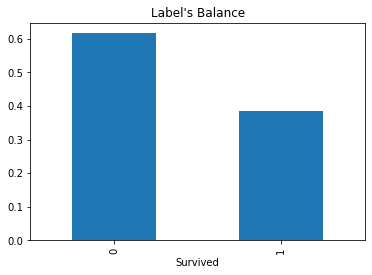

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
print ('survival rate =', titanic.Survived.mean())
(titanic.groupby('Survived').size()/titanic.shape[0]).plot(kind="bar",title="Label's Balance")


In [7]:
# make a function to plot survival against passenger attribute
def survival_rate(column,t):
    df=pd.DataFrame()
    df['total']=titanic.groupby(column).size()
    df['survived'] = titanic.groupby(column).sum()['Survived']
    df['percentage'] = round(df['survived']/df['total']*100,2)
    print(df)

    df['survived'].plot(kind=t)
    df['total'].plot(kind=t,alpha=0.5,title="Survivors per "+str(column))
    plt.show()

        total  survived  percentage
Sex                                
female    314       233       74.20
male      577       109       18.89


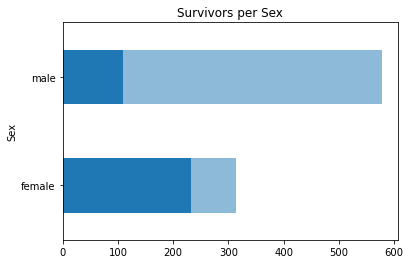

In [8]:
# Draw survival per Sex
survival_rate("Sex","barh")

        total  survived  percentage
Pclass                             
1         216       136       62.96
2         184        87       47.28
3         491       119       24.24


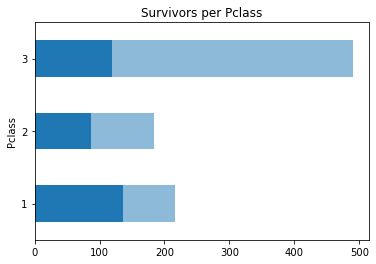

In [9]:
# Draw survival per Class
survival_rate("Pclass","barh")

          total  survived  percentage
Embarked                             
C           168        93       55.36
Q            77        30       38.96
S           646       219       33.90


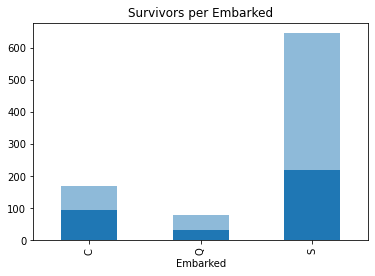

In [10]:
# Graph survived per port of embarkation
survival_rate("Embarked","bar")

       total  survived  percentage
Parch                             
0        678       233       34.37
1        118        65       55.08
2         80        40       50.00
3          5         3       60.00
4          4         0        0.00
5          5         1       20.00
6          1         0        0.00


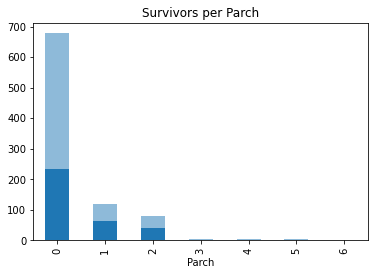

In [11]:
# Draw survived per Number of Parents/Children Aboard (Parch)
survival_rate("Parch", "bar")

       total  survived  percentage
SibSp                             
0        608       210       34.54
1        209       112       53.59
2         28        13       46.43
3         16         4       25.00
4         18         3       16.67
5          5         0        0.00
8          7         0        0.00


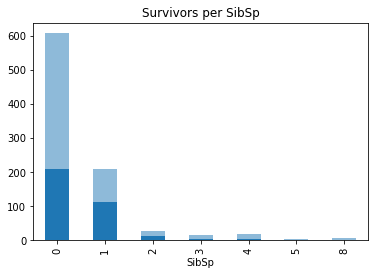

In [12]:
# Draw survived per Number of Siblings/Spouses Aboard (SibSp)
survival_rate("SibSp","bar")

## Model training

Some of the columns don't have predictive power, so let's specify which ones are included for prediction

In [13]:
predictors = ["Pclass", "Sex", "Age", 'SibSp' ,'Parch', "Fare", "Embarked"]  

We need now to convert text columns in **predictors** to numerical ones

In [14]:
for col in predictors: # Loop through all columns in predictors
    if titanic[col].dtype == 'object':  # check if column's type is object (text)
        titanic[col] = pd.Categorical(titanic[col]).codes  # convert text to numerical

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2


In [15]:
# Split the data into a training set and a testing set. Set: test_size=0.3, random_state=1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic[predictors], titanic['Survived'], test_size=0.3, random_state=1)

# X_train, X_test = train_test_split(titanic[predictors], test_size=0.3, random_state=1)
# y_train, y_test = train_test_split(titanic['Survived'], test_size=0.3, random_state=1)

print ("train shape", X_train.shape, y_train.shape)
print ("test shape", X_test.shape, y_test.shape)

train shape (623, 7) (623,)
test shape (268, 7) (268,)


In [16]:
# import LogisticRegression from: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=1)
clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train) #how many good prediction
test_score = clf.score(X_test, y_test)
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)

train accuracy = 0.8073836276083467
test accuracy = 0.7723880597014925


Let's print the model's parameters

In [17]:
coeff = pd.DataFrame()
coeff['Feature'] = X_train.columns
coeff['Coefficient Estimate'] = pd.Series(clf.coef_[0])
coeff.loc[len(coeff)]=['Intercept',clf.intercept_[0]]
print (coeff)

     Feature  Coefficient Estimate
0     Pclass             -1.158693
1        Sex             -2.708761
2        Age             -0.040634
3      SibSp             -0.334012
4      Parch              0.071939
5       Fare             -0.000570
6   Embarked             -0.223307
7  Intercept              5.391546


We now need to predict class labels for the test set. We will also generate the class probabilities

In [18]:
# predict class labels for the test set
y_pred = clf.predict(X_test)
print (y_pred)

[1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0
 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0
 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1
 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 1 1 0 1 1 0 0 1 0]


In [19]:
# generate class probabilities : http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
y_probs = clf.predict_proba(X_test)
print (y_probs)

[[0.13931136 0.86068864]
 [0.91545701 0.08454299]
 [0.12666421 0.87333579]
 [0.36591846 0.63408154]
 [0.07784304 0.92215696]
 [0.89067953 0.10932047]
 [0.80772613 0.19227387]
 [0.1192278  0.8807722 ]
 [0.4986294  0.5013706 ]
 [0.44730682 0.55269318]
 [0.90553196 0.09446804]
 [0.39942798 0.60057202]
 [0.75883956 0.24116044]
 [0.7731844  0.2268156 ]
 [0.3658672  0.6341328 ]
 [0.51884408 0.48115592]
 [0.92555343 0.07444657]
 [0.92813018 0.07186982]
 [0.93745226 0.06254774]
 [0.23336025 0.76663975]
 [0.92721774 0.07278226]
 [0.89953161 0.10046839]
 [0.03807371 0.96192629]
 [0.70151645 0.29848355]
 [0.27209455 0.72790545]
 [0.91229354 0.08770646]
 [0.06263095 0.93736905]
 [0.28628341 0.71371659]
 [0.75835591 0.24164409]
 [0.05700656 0.94299344]
 [0.36148887 0.63851113]
 [0.51940621 0.48059379]
 [0.52697884 0.47302116]
 [0.47141331 0.52858669]
 [0.93503278 0.06496722]
 [0.48609828 0.51390172]
 [0.59876812 0.40123188]
 [0.91543127 0.08456873]
 [0.46440472 0.53559528]
 [0.88665975 0.11334025]


As you can see, the classifier outputs two probabilities for each row. It's predicting a 1 (Survived) any time the probability in the second column is greater than 0.5. Let's visualize it all together.

In [20]:
pred = pd.DataFrame({        
        "Survived_original": y_test,
        "Survived_predicted": y_pred,
        "Survived_proba": np.transpose(y_probs)[1]      
        })
pred["Comparison"]= pred.Survived_original ==pred.Survived_predicted
pred.head()

,Survived_original,Survived_predicted,Survived_proba,Comparison
862,1,1,0.860689,True
223,0,0,0.084543,True
84,1,1,0.873336,True
680,0,1,0.634082,False
535,1,1,0.922157,True


## Confusion matrix

In [21]:
from sklearn import metrics
print (metrics.confusion_matrix(y_test, y_pred))
print (metrics.classification_report(y_test, y_pred))

[[129  24]
 [ 37  78]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       153
           1       0.76      0.68      0.72       115

    accuracy                           0.77       268
   macro avg       0.77      0.76      0.76       268
weighted avg       0.77      0.77      0.77       268



As you can see, we can have the classification report for each class

## K-Fold Cross Validation

In [23]:
# import cross_validation from: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(random_state=1)
scores = cross_val_score(clf, titanic[predictors], titanic["Survived"], scoring='accuracy', cv=5)
## see model 
print(scores)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

[0.7877095  0.78651685 0.78089888 0.76966292 0.82022472]
0.7890025735986442


When you are improving a model, you want to make sur that you are really doing it and not just being lucky. This is why it's good to work with cross validation instead of one train/test split.